In [287]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [41]:
df = pd.read_csv("Customer Churn.csv")

In [42]:
df.columns = df.columns.str.lower().str.replace(r'\s+', '_', regex=True)

In [289]:
# The 'tariff_plan' and 'status' columns are binary, but use 2 and 1 instead of the standard 0 and 1.
# This code replaces all occurrences of 2 with 0 to standardize the binary format.
df[['tariff_plan', 'status']] = df[['tariff_plan', 'status']].replace(2, 0)

In [291]:
# Generate summary statistics
summary_stats = df.describe().transpose()

# Style the table
styled_summary = summary_stats.style.format("{:.2f}")\
    .set_caption("Summary Statistics")

# Display the styled table
styled_summary

,count,mean,std,min,25%,50%,75%,max
call_failure,3150.00,7.63,7.26,0.00,1.00,6.00,12.00,36.00
complains,3150.00,0.08,0.27,0.00,0.00,0.00,0.00,1.00
subscription_length,3150.00,32.54,8.57,3.00,30.00,35.00,38.00,47.00
charge_amount,3150.00,0.94,1.52,0.00,0.00,0.00,1.00,10.00
seconds_of_use,3150.00,4472.46,4197.91,0.00,1391.25,2990.00,6478.25,17090.00
frequency_of_use,3150.00,69.46,57.41,0.00,27.00,54.00,95.00,255.00
frequency_of_sms,3150.00,73.17,112.24,0.00,6.00,21.00,87.00,522.00
distinct_called_numbers,3150.00,23.51,17.22,0.00,10.00,21.00,34.00,97.00
age_group,3150.00,2.83,0.89,1.00,2.00,3.00,3.00,5.00
tariff_plan,3150.00,0.92,0.27,0.00,1.00,1.00,1.00,1.00


In [285]:
# Check for null values
null_counts = df.isnull().sum()

print(null_counts)

call_failure               0
complains                  0
subscription_length        0
charge_amount              0
seconds_of_use             0
frequency_of_use           0
frequency_of_sms           0
distinct_called_numbers    0
age_group                  0
tariff_plan                0
status                     0
age                        0
customer_value             0
churn                      0
dtype: int64


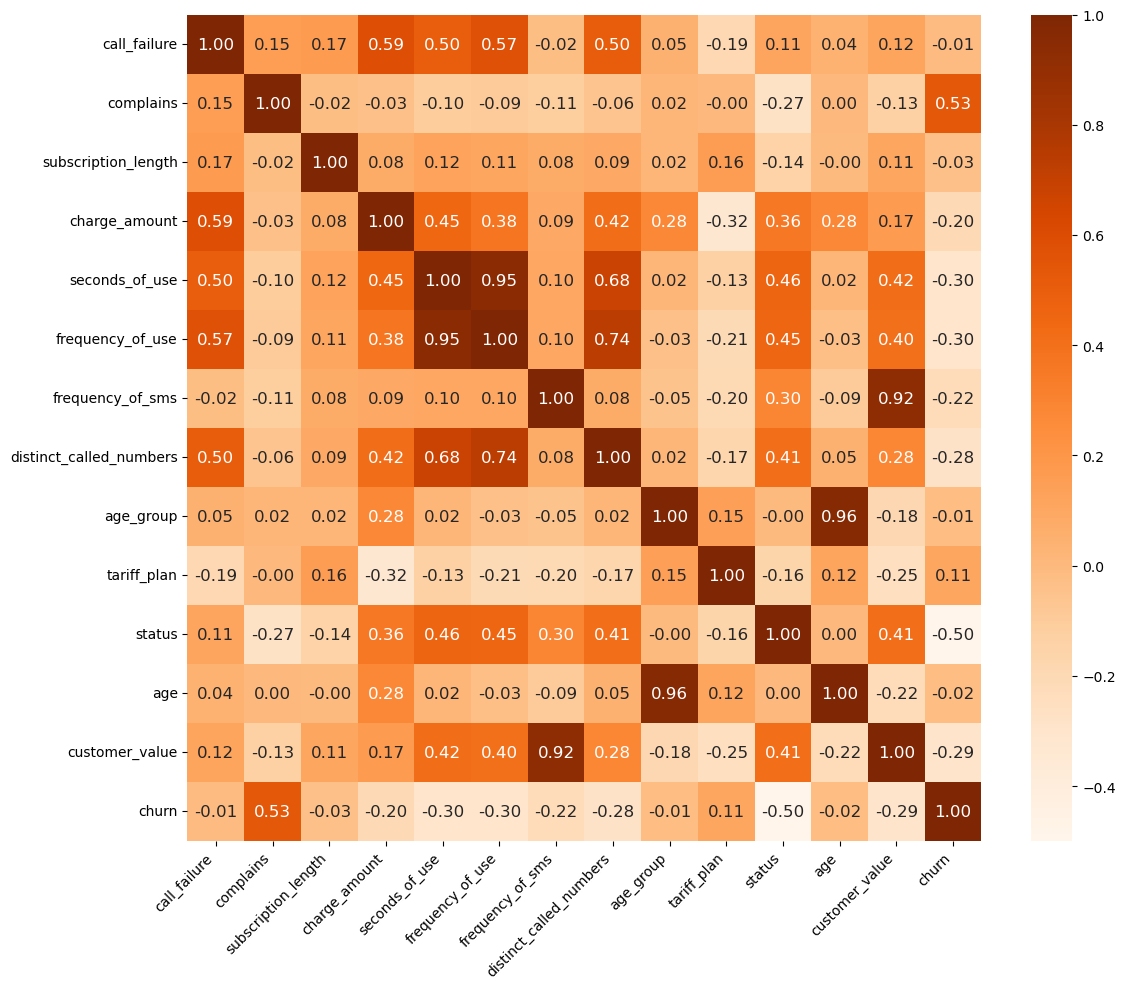

In [493]:
# Create correlation table and plot
corr_table = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_table, annot=True, annot_kws={"size": 12}, fmt=".2f", cmap="Oranges")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Add this to prevent label cutoff
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')  # Add bbox_inches='tight' to prevent label cutoff
plt.show()
plt.close()

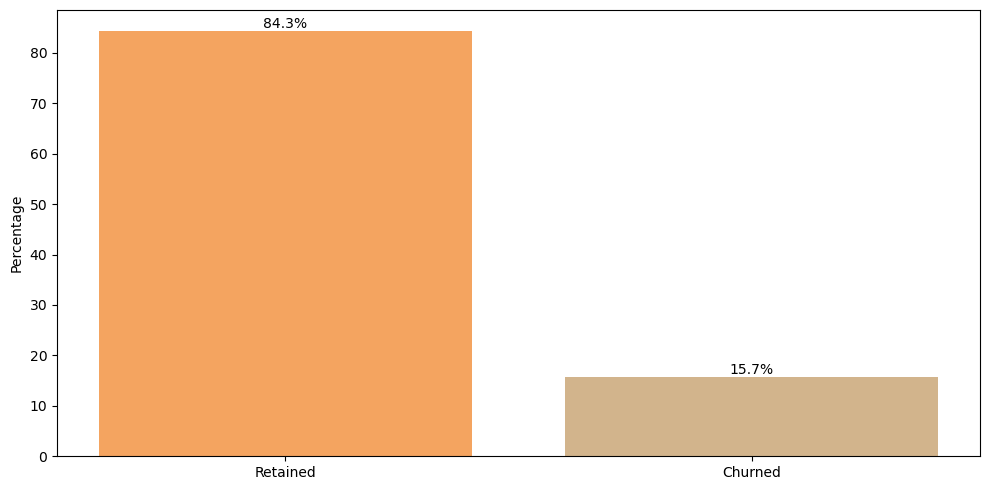

In [499]:
# Calculate the values
churn_counts = df.churn.value_counts()
total = churn_counts.sum()
percentages = (churn_counts / total * 100)

# Create the bar plot
plt.figure(figsize=(10, 5))
bars = plt.bar([0, 1], percentages, color=['sandybrown', 'tan'])
plt.ylabel('Percentage')

# Add x-axis labels
plt.xticks([0, 1], ['Retained', 'Churned'])

# Add percentage labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{percentages[i]:.1f}%',
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig('churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns
from itertools import product
from typing import Tuple, Dict, Any, Optional

class ChurnModel:
    def __init__(self, random_state: int = 7):
        self.random_state = random_state
        self.model = None
        self.best_params = None
        
    def prepare_data(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
        df.columns = df.columns.str.lower().str.replace(r'\s+', '_', regex=True)
        
        if 'churn' not in df.columns:
            raise ValueError("'churn' column not found in dataset")
        
        df['churn'] = pd.to_numeric(df['churn'], errors='coerce')
        df = df.dropna()
        
        X = pd.get_dummies(df.drop('churn', axis=1), drop_first=True)
        y = df['churn']
        
        return train_test_split(
            X, y, test_size=0.1, random_state=self.random_state, stratify=y
        )
    
    @staticmethod
    def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_pred_proba: np.ndarray) -> Dict[str, float]:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        n_samples = len(y_true)
        
        return {
            'accuracy': (tp + tn) / n_samples,
            'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
            'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'f1': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0,
            'auc': roc_auc_score(y_true, y_pred_proba),
            'tn_rate': tn / n_samples,
            'fp_rate': fp / n_samples,
            'fn_rate': fn / n_samples,
            'tp_rate': tp / n_samples
        }
    
    def plot_results(self, metrics: Dict[str, float], y_test: np.ndarray, y_pred: np.ndarray, 
                y_pred_proba: np.ndarray) -> None:
        # Plot Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap=sns.light_palette("orange", as_cmap=True), 
                   xticklabels=['No Churn', 'Churn'], 
                   yticklabels=['No Churn', 'Churn'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.savefig(f"confusion_matrix.png", dpi=300)
        plt.close()
    
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', 
                label=f'ROC curve (AUC = {metrics["auc"]:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.02])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.grid()
        plt.tight_layout()
        plt.savefig(f"roc_auc_curve.png", dpi=300)
        plt.close()
    
        # Add Feature Importance Plot
        importance_scores = self.model.feature_importances_
        feature_names = self.model.feature_names_in_
        
        # Sort features by importance
        indices = np.argsort(importance_scores)[::-1]
        
        # Plot top 15 features
        plt.figure(figsize=(10, 6))
        plt.barh(range(min(15, len(feature_names)))[::-1],
                importance_scores[indices][:15],
                color="orange")
        
        plt.yticks(range(min(15, len(feature_names)))[::-1], 
                  [feature_names[i] for i in indices][:15])
        plt.xlabel('Feature Importance')
        plt.tight_layout()
        plt.savefig(f"feature_importance.png", dpi=300)
        plt.close()

    def tune_model(self, X_train: pd.DataFrame, y_train: pd.Series, 
                  param_grid: Optional[Dict[str, list]] = None) -> None:
        if param_grid is None:
            param_grid = {
                'max_depth': [5, 7, 10, 15, 20, 25],
                'learning_rate': [0.1],
                'subsample': [0.8, 0.9],
                'colsample_bytree': [0.8, 0.9],
                'min_child_weight': [1],
                'scale_pos_weight': [(y_train == 0).sum() / (y_train == 1).sum()]
            }
        
        kf = KFold(n_splits=5, shuffle=True, random_state=self.random_state)
        
        best_score = -np.inf
        total_combinations = np.prod([len(v) for v in param_grid.values()])
        print(f"\nTesting {total_combinations} parameter combinations...")
        
        for params in self._param_combinations(param_grid):
            scores = []
            for train_idx, val_idx in kf.split(X_train):
                X_train_cv = X_train.iloc[train_idx]
                X_val_cv = X_train.iloc[val_idx]
                y_train_cv = y_train.iloc[train_idx]
                y_val_cv = y_train.iloc[val_idx]
                
                model = xgb.XGBClassifier(
                    objective='binary:logistic',
                    random_state=self.random_state,
                    eval_metric='auc',
                    **params
                )
                
                model.fit(X_train_cv, y_train_cv)
                y_pred_proba = model.predict_proba(X_val_cv)[:, 1]
                scores.append(roc_auc_score(y_val_cv, y_pred_proba))
            
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                self.best_params = params
        
        print(f"Best CV score: {best_score:.4f}")
        print(f"Best parameters: {self.best_params}")
    
    @staticmethod
    def _param_combinations(param_grid: Dict[str, list]):
        keys = list(param_grid.keys())
        values = list(param_grid.values())
        for combination in product(*values):
            yield dict(zip(keys, combination))
    
    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        if self.best_params is None:
            raise ValueError("Must run tune_model before fitting")
            
        self.model = xgb.XGBClassifier(
            objective='binary:logistic',
            random_state=self.random_state,
            eval_metric='auc',
            **self.best_params
        )
        self.model.fit(X_train, y_train)
    
    def predict(self, X: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        if self.model is None:
            raise ValueError("Model not fitted")
        return self.model.predict(X), self.model.predict_proba(X)[:, 1]

def main(df_path: str) -> None:
    try:
        print("Loading data...")
        df = pd.read_csv(df_path)
        model = ChurnModel()
        
        print("Preparing data...")
        X_train, X_test, y_train, y_test = model.prepare_data(df)
        
        print("\nTuning model parameters...")
        model.tune_model(X_train, y_train)
        
        print("\nTraining final model...")
        model.fit(X_train, y_train)
        
        print("\nGenerating predictions and metrics...")
        y_pred, y_pred_proba = model.predict(X_test)
        metrics = model.calculate_metrics(y_test, y_pred, y_pred_proba)
        model.plot_results(metrics, y_test, y_pred, y_pred_proba)
        
        print("\nModel Performance Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
            
    except Exception as e:
        print(f"Error in execution: {str(e)}")
        raise

if __name__ == "__main__":
    main("Customer Churn.csv")

Loading data...
Preparing data...

Tuning model parameters...

Testing 24 parameter combinations...
